# Load and subset data

In [1]:
#Adds higher directory to path, so we can access /ATS
import sys
sys.path.append("../")

from ATS.general import *
from ATS.QAQC import *

import pandas as pd
import numpy

# Set the DataFram in pandas to show all columns and 1000 rows. Display plots inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

<Item title:"SAC_Enhancement_Vegetation_Cover_RT" type:Feature Layer Collection owner:Anooshi>
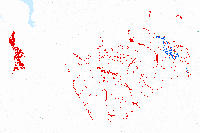

In [2]:
# Load data from arcGIS online
output = arcGIS_data_load('6bd6243e209040aabf2c6a9427fbfdd9')

layer = output['data0']
records = output['table0']
feature_service = output['feature_service']

In [4]:
# Merge related table and feature layer
data = layer.merge(records, left_on='GlobalID', right_on='Feature_ID', how='inner')
data = data.drop(columns=['GlobalID_x','Feature_ID'])
data = data.rename(columns={'OBJECTID_x':'Feature_ID','GlobalID_y':'Record_GlobalID', 'OBJECTID_y':'Record_ID'})
data.head()

,Feature_ID,Habitat,BHR_Site,Surveyor_1,Surveyor_2,Observation_Date,FldPntTyp,Comments,Azimuth,Point_ID,SHAPE,Record_ID,Height_Cat,Species_Sci,Record_GlobalID,Cal_IPC_Rating,Native,RWQCB_Permit_Hydro,RWQCB_Permit_ACOE_Hydro
0,81,Willow Riparian,SAC,Richard Graham-Bruno,Kevin Sherrill,2020-05-07 17:48:46,Intended Habitat,None,276,WR1,"{'x': 6188454.324027394, 'y': 2036210.04499405...",627,3,Salix laevigata,098780c3-1671-45c8-a999-f3315597f55a,None,True,True,True
1,81,Willow Riparian,SAC,Richard Graham-Bruno,Kevin Sherrill,2020-05-07 17:48:46,Intended Habitat,None,276,WR1,"{'x': 6188454.324027394, 'y': 2036210.04499405...",628,2,Salix laevigata,dd7b9c2c-8d90-406b-81c0-2f838a482a32,None,True,True,True
2,82,Willow Riparian,SAC,Richard Graham-Bruno,Kevin Sherrill,2020-05-07 16:44:11,Intended Habitat,None,34,WR2,"{'x': 6187645.635298163, 'y': 2036918.34423699...",590,3,Salix laevigata,0a46b233-a690-4625-bc58-56eade033a12,None,True,True,True
3,82,Willow Riparian,SAC,Richard Graham-Bruno,Kevin Sherrill,2020-05-07 16:44:11,Intended Habitat,None,34,WR2,"{'x': 6187645.635298163, 'y': 2036918.34423699...",591,1,Bromus diandrus,4a68fb10-5bb9-45b4-90de-a6527a87baa9,Moderate,None,None,None
4,82,Willow Riparian,SAC,Richard Graham-Bruno,Kevin Sherrill,2020-05-07 16:44:11,Intended Habitat,None,34,WR2,"{'x': 6187645.635298163, 'y': 2036918.34423699...",592,1,Pseudognaphalium luteoalbum,983567e8-efd4-47ca-91b0-f7bf7be5410c,None,None,None,None


# Subset Data

In [6]:
# Subset by year
sYear = input("Start Year? (YYYY)")
sub = year_subset(data, sYear)

Start Year? (YYYY) 2019

Analysis for 2019-10-01 07:00 UTC to 2020-10-01 07:00 UTC
Entries in Subset: 434


# Update Ratings and Catagories through API

In [0]:
############ Species Lists
pltDir = r"/home/user/SAC/Script Support Files/SAC Master Plant Species List 20191114.xlsx"
pltSheet = "Year 5 Plant Species List"

verif = input("Current Plant Species List file location:\n"+pltDir+"\nCurrent Sheet Name:\n"+pltSheet+"\n\nIs this correct? (Y/N)")


if verif=="Y":
    # Will need to update this file locally on the G drive and change the sheet name
    pltLst = pd.read_excel(pltDir, pltSheet)

    #Clean lists
    for col in ['Native','Cal-IPC Rating','RWQCB Permit Hydrophyte1', 'RWQCB Permit USACE Hydrophyte2','Species']:
        pltLst[col] = text_cleaner(pltLst[col])
    
    #Get CAL IPC High list
    Cal_IPC_H = pltLst.loc[pltLst['Cal-IPC Rating'] == "High", 'Species'].tolist()
    
    #Get CAL IPC Moderate list
    Cal_IPC_M = pltLst.loc[pltLst['Cal-IPC Rating'] == "Moderate", 'Species'].tolist()

    # Get native species list
    Native = pltLst.loc[pltLst["Native"]=="Native","Species"].tolist()

    # Get RWQCB Permit Hydro List
    RWQCB = pltLst.loc[pltLst["RWQCB Permit Hydrophyte1"]=="x","Species"].tolist()
    
    # Get RWQCB Permit / USACOE Hydro List
    RWQCB_USACE = pltLst.loc[pltLst["RWQCB Permit USACE Hydrophyte2"]=="x","Species"].tolist()
    
    print("Done")
    
else:
    print("\nChange directory and sheet in code")

In [0]:
#Update records
# Get all records
VC_records = feature_service.tables[0].query(return_all_records=True)

edits = []

#loop through each feature
for feature in VC_records.features:
    
    species = feature.attributes['Species_Sci']
    update_flag = False

    if species in Cal_IPC_H:
        feature.attributes['Cal_IPC_Rating'] = 'High'
        update_flag = True

    if species in Cal_IPC_M:
        feature.attributes['Cal_IPC_Rating'] = 'Moderate'
        update_flag = True

    if species in Native:
        feature.attributes['Native'] = 'True'
        update_flag = True

    if species in RWQCB:
        feature.attributes['RWQCB_Permit_Hydro'] = 'True'
        update_flag = True

    if species in RWQCB_USACE:
        feature.attributes['RWQCB_Permit_ACOE_Hydro'] = 'True'
        update_flag = True

    #if an change was made, update through API
    if update_flag:
        edits.append(feature)

#send updates if edit was made
if edits:
    #send updates
    result = feature_service.tables[0].edit_features(updates=edits)

    #Check if update was successful
    fail_flag = False
    for item in result['updateResults']:
        if not item['success']:
            fail_flag = True
            print('Could not update feature, Object ID: ',item['objectId'])

    if not fail_flag:
        print('Successfully updated features')
        
else:
    print('No edits made')

# QAQC

In [11]:
QAQC_whitespace(data, objectID=['Record_GlobalID'])



Analysis for: Habitat
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: BHR_Site
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Surveyor_1
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Surveyor_2
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: FldPntTyp
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Comments
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Point_ID
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: SHAPE
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white spa

In [12]:
#QAQC Check number of records matches on ArcGIS online
print('Subset \n# of rows:\n', sub.shape[0])
print('# of columns:\n',sub.shape[1])

Subset 
# of rows:
 434
# of columns:
 19


In [13]:
find_blank_entries(data, exclude_cols=['Cal_IPC_Rating','RWQCB_Permit_Hydro','Comments', 'RWQCB_Permit_ACOE_Hydro','Native','Surveyor_2'])

No blank Record_ID
No blank Feature_ID
No blank Record_GlobalID
No blank Point_ID
No blank SHAPE
No blank Observation_Date
No blank Azimuth
No blank Habitat
No blank Surveyor_1
No blank FldPntTyp
No blank BHR_Site
No blank Species_Sci
No blank Height_Cat


../ATS/QAQC.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plt_r,plt_c].set_xticklabels(r['DateString'], rotation='vertical')


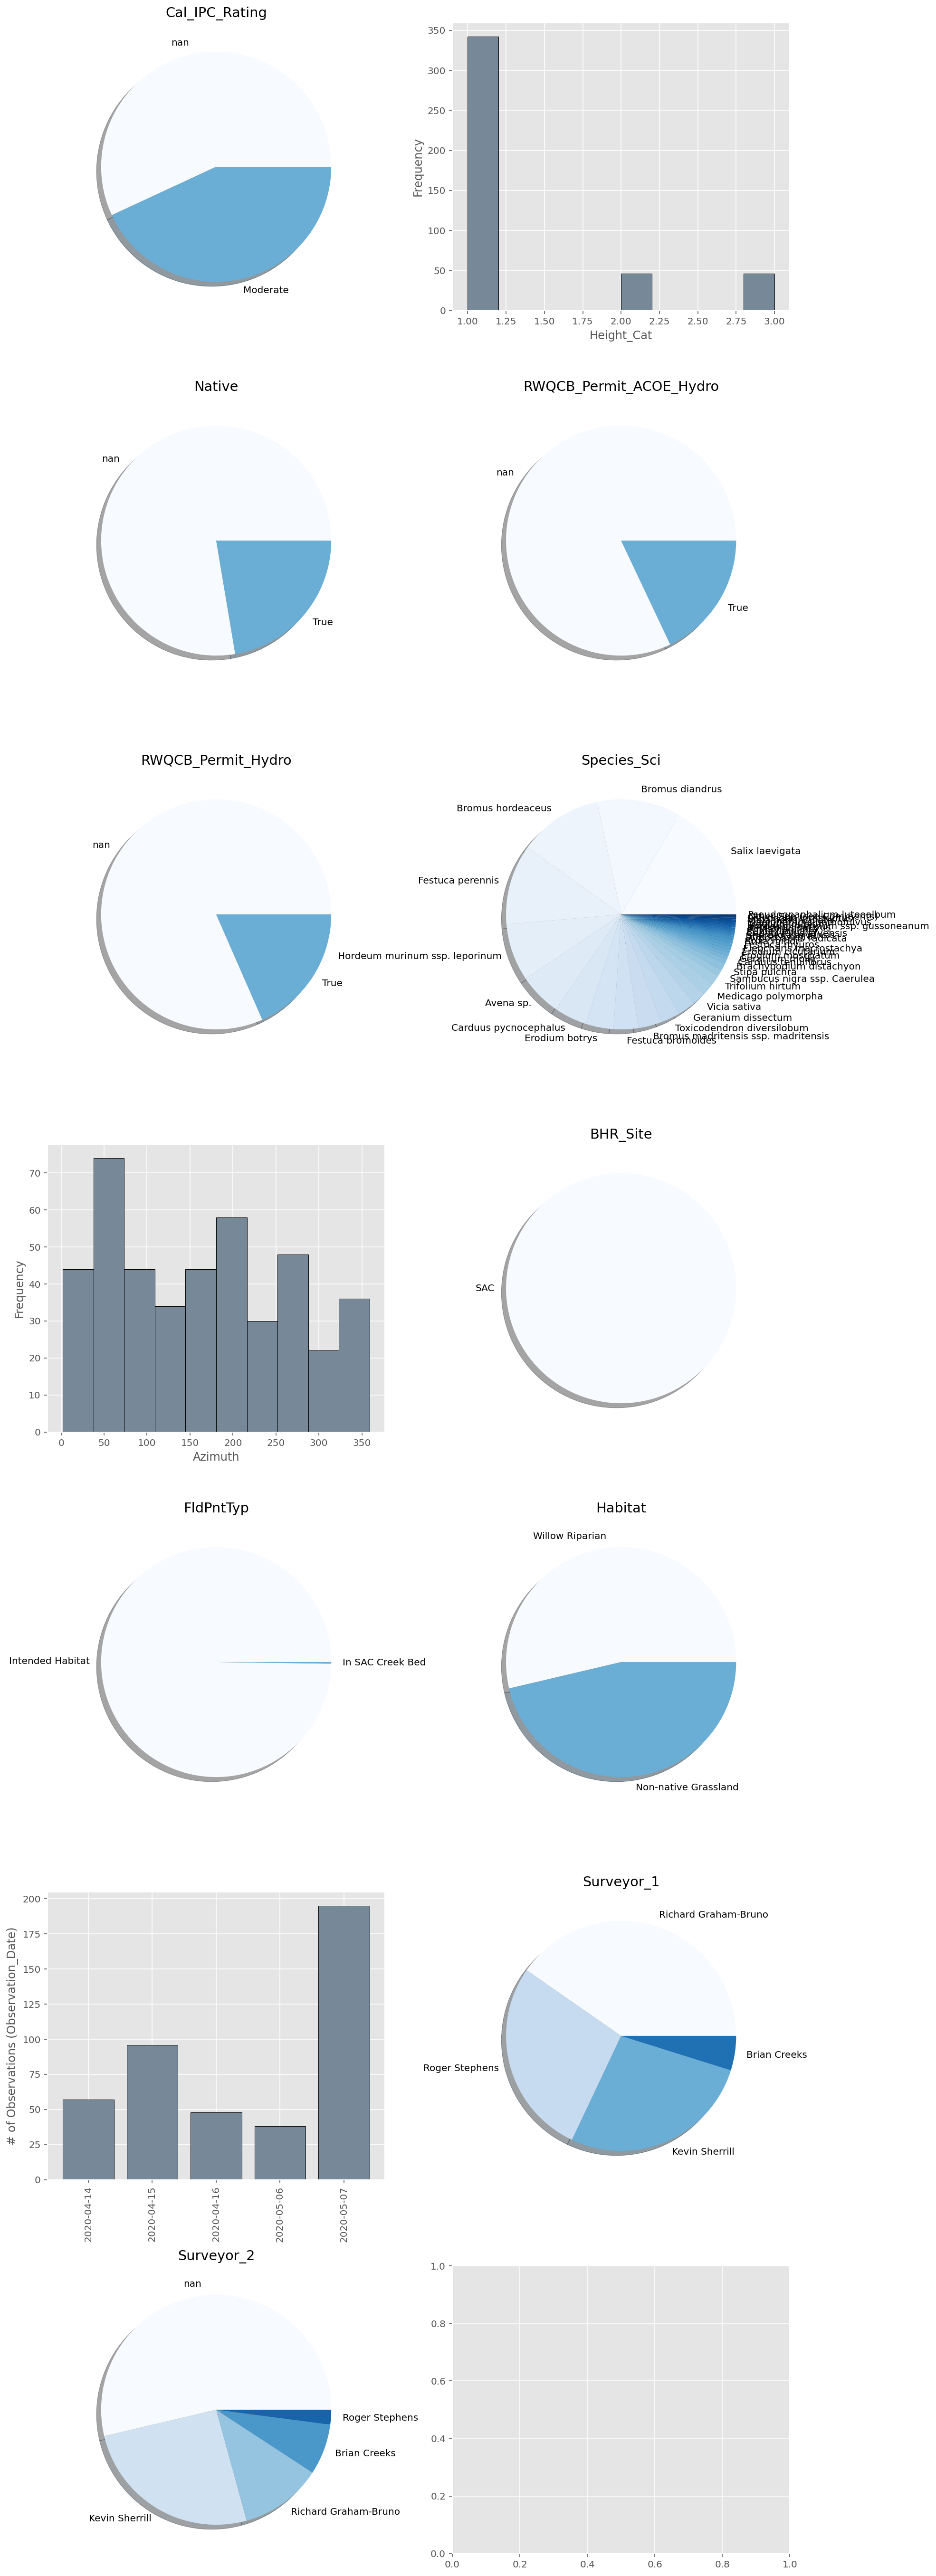

In [14]:
QAQC_plot(sub, ['Cal_IPC_Rating', 'Height_Cat', 'Native',
       'RWQCB_Permit_ACOE_Hydro', 'RWQCB_Permit_Hydro', 'Species_Sci',
       'Azimuth', 'BHR_Site', 'FldPntTyp', 'Habitat', 'Observation_Date',
       'Surveyor_1', 'Surveyor_2'])

ERROR: RWQCB_Permit_ACOE_Hydro does not contain values.
ERROR: RWQCB_Permit_Hydro does not contain values.


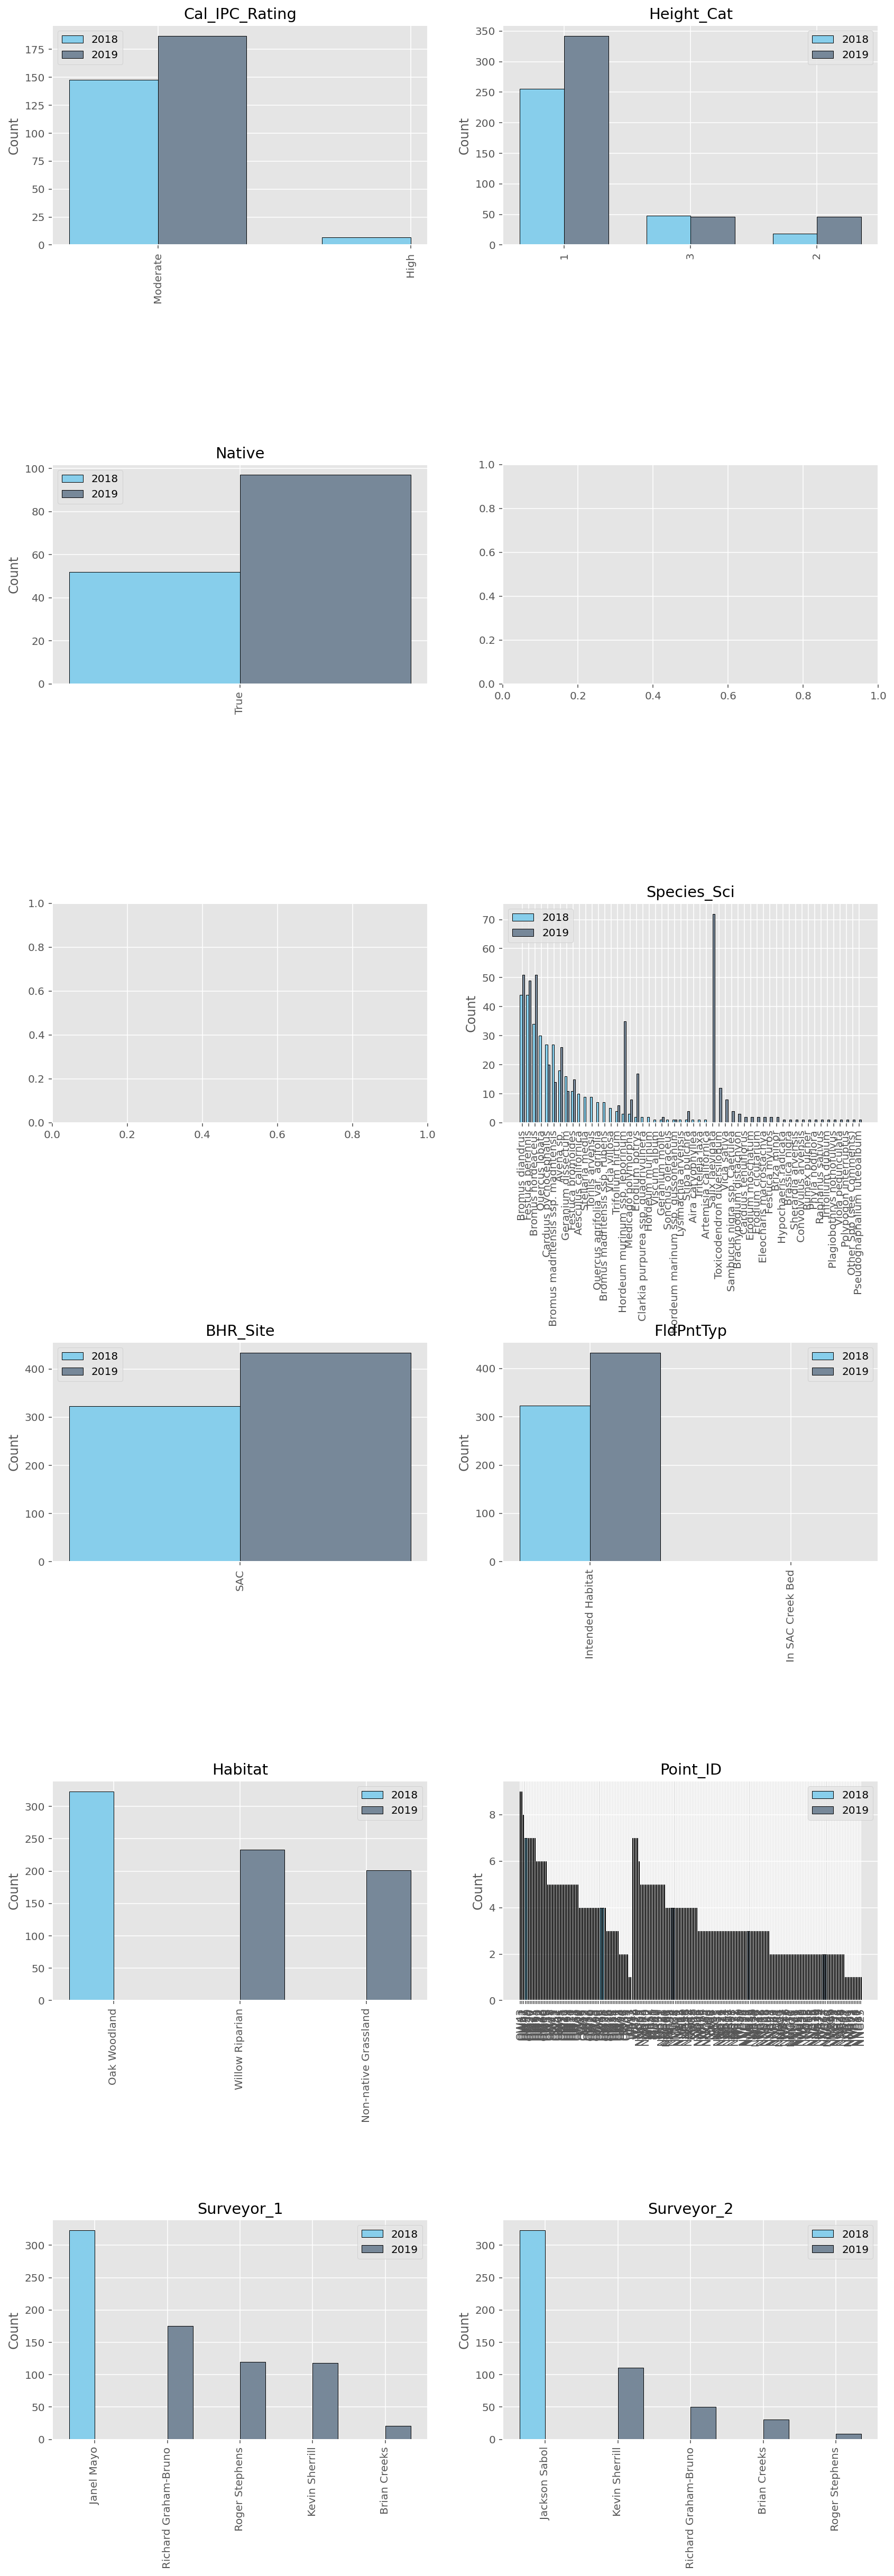

In [15]:
compare_years_catagorical(data, ['Cal_IPC_Rating', 'Height_Cat', 'Native', 
       'RWQCB_Permit_ACOE_Hydro', 'RWQCB_Permit_Hydro', 'Species_Sci',
       'BHR_Site', 'FldPntTyp', 'Habitat',
       'Surveyor_1', 'Surveyor_2'], '2018', '2019')

In [0]:
#Check file names
QAQC_attachment_filenames(feature_service)

# Analysis

In [0]:
#Convert string to boolean for presence/absence columns
sub['Native'] = (sub['Native']=='True')
sub['RWQCB_Permit_ACOE_Hydro'] = (sub['RWQCB_Permit_ACOE_Hydro']=='True')
sub['RWQCB_Permit_Hydro'] = (sub['RWQCB_Permit_Hydro']=='True')

In [0]:
#Count of points collected
pointCount = sub.groupby('Habitat').Point_ID.nunique()
print("Count of Observed Points by Habitat:")
print(pointCount.to_string(index=True), '\n\n')

print("Total Count:\n", sub.Point_ID.nunique())

In [0]:
# Count of plots with native matches
print("Count of plots with native plants:")
print(sub.groupby('Point_ID').Native.any().sum())

# Count of plots with native matches by habitat
print("\nCount of plots with native plants by habitat:")
Count_by_ID_Hab = sub.groupby(['Point_ID','Habitat']).Native.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# Native % of observations
print("\nNative Vegetation Cover (%) by Habitat:\n")
print ((nHits/pointCount)*100)

In [0]:
#RWQCB Permit Hydrophytic cover
print("  Count of plots with RWQCB Permit Hydro Natives:")
print(sub.groupby('Point_ID').RWQCB_Permit_Hydro.any().sum())

# RWQCB hydro native count grouped by the habitat. 
Count_by_ID_Hab = sub.groupby(['Point_ID','Habitat']).RWQCB_Permit_Hydro.any()
hydroHits =  Count_by_ID_Hab.groupby(['Habitat']).sum()
print("\n \n  Count of RWQCB Permit Hydro Native by Habitat: \n")
print(hydroHits.to_string(index=True))

# Native % of observations
print("\n\n  Absolute Native Hydrophytic Plant Cover by Habitat:\n")
print(round((hydroHits / pointCount ) * 100,2).to_string(index=True))

In [0]:
# Find NNIP High matches
print('Count of plots with NNIP High Hits')
NNIP_high = sub.loc[sub['Cal_IPC_Rating']=='High',:]
print(len(NNIP_high))

# Count the points that hit an NNIP high grouped by the habitat. 
hHits = NNIP_high.groupby('Habitat').Species_Sci.count()
print("\n \n Count of NNIP High by Habitat:")
print(hHits.to_string(index=True))

# NNIP % of observations
print("\n\n  NNIP Cover (%) by Habitat:\n")
print(round((hHits / pointCount ) * 100,2).to_string(index=True))

print('\n\nNNIP High Records:')
display(NNIP_high)

In [0]:
#Species richness
print('Species Richness:', sub['Species_Sci'].nunique())

In [0]:
# Abundance and Relative abundance site wide
abundance = sub['Species_Sci'].value_counts() #Abundance of each species
observations = abundance.sum() # Count of observations across site

rAbun = pd.DataFrame(abundance / observations) #Relative abundence
rAbun = rAbun.rename(index=str, columns={"Species_Sci": "RelAbundence"})

print("Abundance:\n\n",abundance,"\n\n")

print("Relative Abundance:\n", rAbun)

In [0]:
#Relative abundance plot
rAbun.sort_values(by=['RelAbundence'],ascending=False).plot.bar(figsize=(20, 10))
plt.ylabel('Relative Abundance (%)', fontsize=18)

In [0]:
# Shannon index for entire site
elmt = rAbun * numpy.log(rAbun)
shannon_site = elmt.sum()*-1

print("Shannon Index for entire site:\n",shannon_site.to_string(index=False))

In [0]:
# Simpson entire site
elmt = rAbun**2
simpson_site = 1/elmt.sum()

print("Simpson Index for entire site:\n",simpson_site.to_string(index=False))